In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Category Distribution
First, let's visualize the distribution of resumes across different categories.

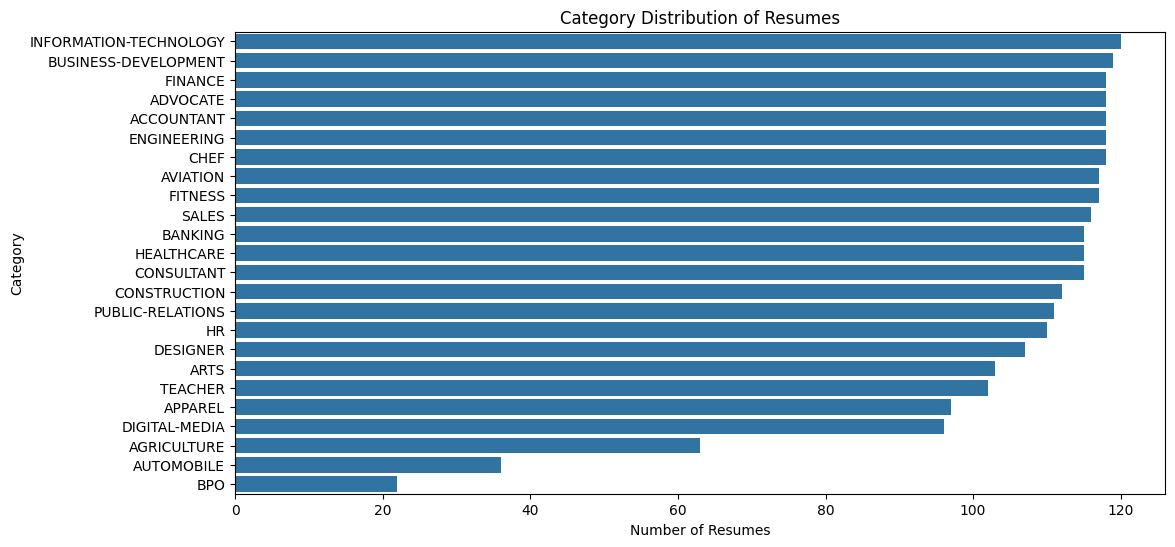

Amount of CVs in the original dataset: 2483


In [77]:
# Load the dataset
df = pd.read_csv('dataset/Resume/cleaned-Resume.csv')

# Visualize the distribution of resumes across different categories
def visualize_distribution(df):
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, y='Category', order=df['Category'].value_counts().index)
    plt.title('Category Distribution of Resumes')
    plt.xlabel('Number of Resumes')
    plt.ylabel('Category')
    plt.show()

visualize_distribution(df)

# Print the amount of CVs in the original dataset
print("Amount of CVs in the original dataset:", df.shape[0])

The data seems uneven. For now, let's remove categories with less than 100 applicants

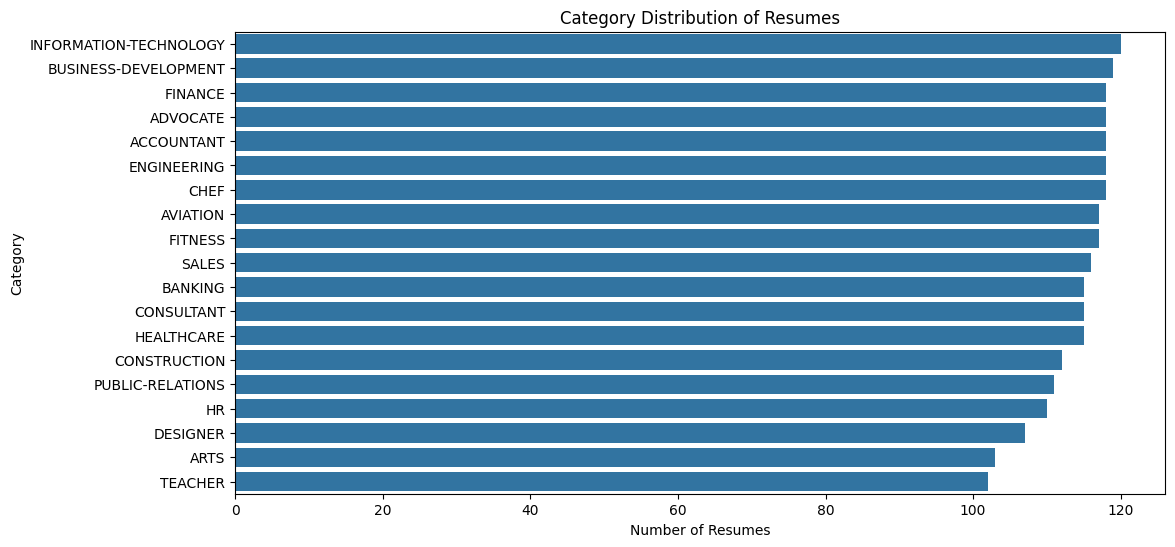

Amount of CVs in the dataset after filtering categories with less than 100 applicants: 2169


In [78]:
# Remove categories with less than 100 resumes
category_counts = df['Category'].value_counts()
filtered_categories = category_counts[category_counts >= 100].index
df_filtered = df[df['Category'].isin(filtered_categories)]

# Visualize the filtered data
visualize_distribution(df_filtered)

# Print the amount of CVs in the current dataset
print("Amount of CVs in the dataset after filtering categories with less than 100 applicants:", df_filtered.shape[0])

# Text Analysis: Word Clouds
Next, let's generate word clouds for different categories to understand the common words used. We'll can use the WordCloud library for this.

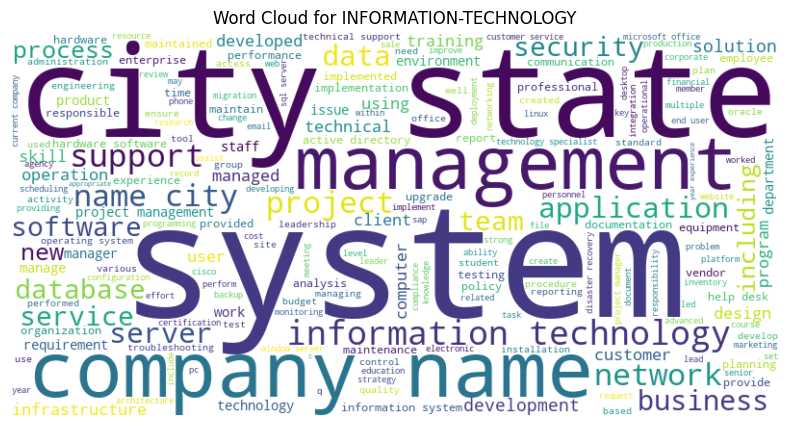

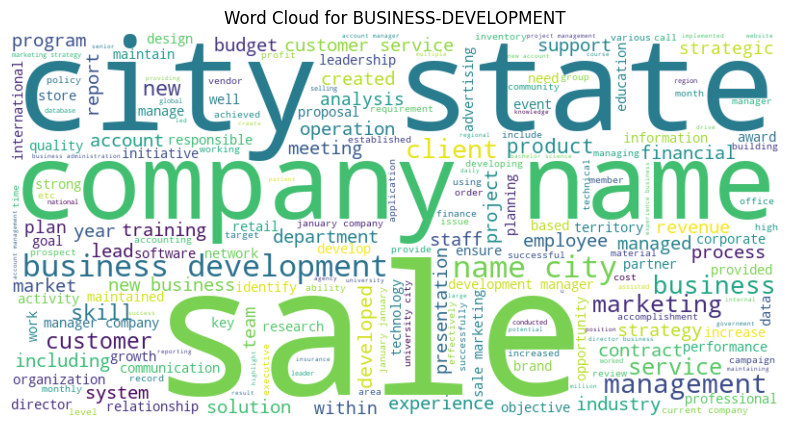

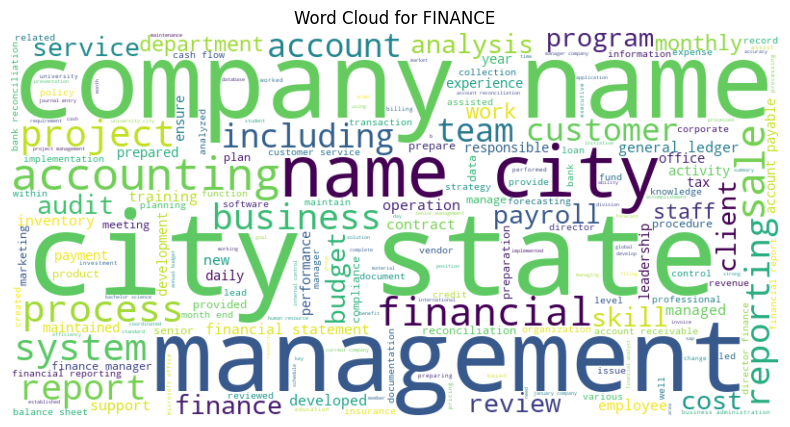

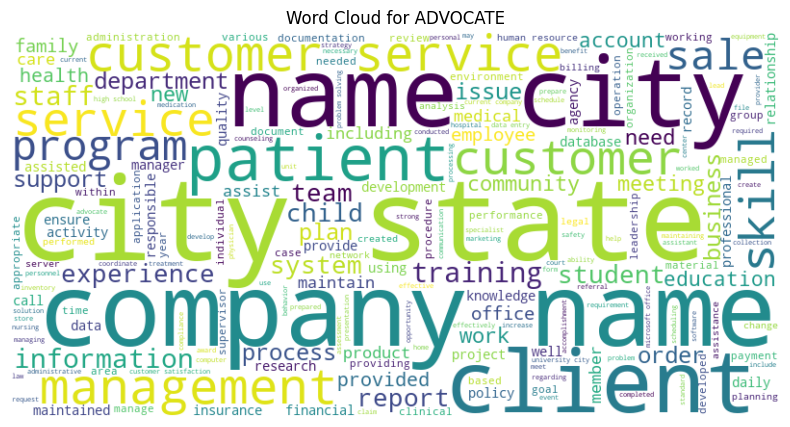

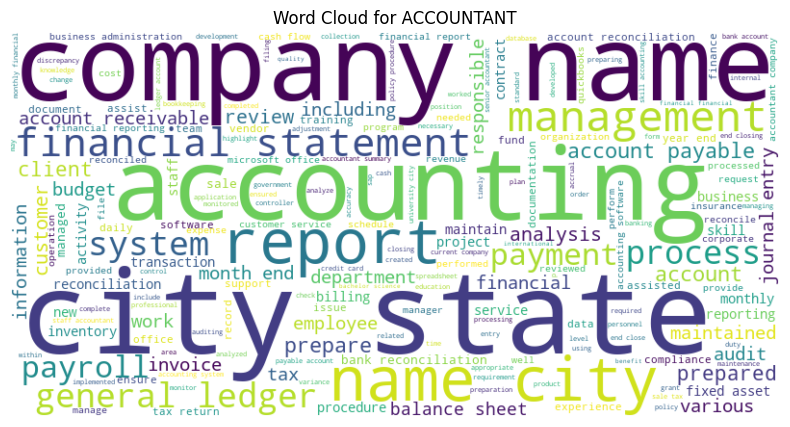

In [79]:
from wordcloud import WordCloud

# Function to generate word cloud for a specific category
def generate_wordcloud(data, category):
    text = " ".join(resume for resume in data[data['Category'] == category]['Resume_str'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {category}')
    plt.axis('off')
    plt.show()

# Generate word clouds for the top 5 categories
top_categories = df_filtered['Category'].value_counts().index[:5]
for category in top_categories:
    generate_wordcloud(df_filtered, category)


Many of the most common words in all categories are irrelevant, words such as city, state, company and name.
Let's use TF-IDF to remove these words

FOR TESTING ONLY, sample the dataset (unused otherwise)

In [80]:
# Sample 10 items in each category
occurrences_per_category = 10
# Get the number of unique categories
categories = df_filtered['Category'].unique()

# Create a balanced subset
df_sampled = pd.DataFrame()

for category in categories:
    category_subset = df_filtered[df_filtered['Category'] == category].sample(n=occurrences_per_category, random_state=42)
    df_sampled = pd.concat([df_sampled, category_subset])

# Print the shape of the balanced subset
print("Balanced subset shape:", df_sampled.shape)


Balanced subset shape: (190, 3)


Calculate mean TF-IDF score for each word

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Group by category and concatenate all resumes in each category into one large string
category_texts = df_filtered.groupby('Category')['Resume_str'].apply(' '.join).reset_index()

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the concatenated text data
X_tfidf = vectorizer.fit_transform(category_texts['Resume_str'])

# Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Convert the TF-IDF matrix to a DataFrame for easier manipulation
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)

# Calculate mean TF-IDF score for each word
mean_tfidf_scores = tfidf_df.mean(axis=0)

Filter out words that are common in all categories

In [82]:
# Set a threshold to filter out common words (e.g., words with a TF-IDF score below 0.1)
threshold = 0.1

# Calculate mean TF-IDF score for each word
mean_tfidf_scores = tfidf_df.mean(axis=0)

# Identify common words
common_words = mean_tfidf_scores[mean_tfidf_scores < threshold].index.tolist()

# Function to remove common words from resume
def remove_common_words(text, common_words):
    return ' '.join([word for word in text.split() if word in common_words])

# Remove common words from the resumes
# Apply the function to the resume texts
df_filtered.loc[:, 'Cleaned_Resume_str'] = df_filtered['Resume_str'].apply(lambda x: remove_common_words(x, common_words))


To see how this helped, let's generate new wordclouds:

In [94]:
df_filtered_new = df[df['Category'].isin(filtered_categories)]
df_filtered.loc[:, 'Cleaned_Resume_str'] = df_filtered['Resume_str']
df_filtered.loc[:, 'Resume_str'] = df_filtered_new['Resume_str']

original resume:
 hr specialist u hr operation summary versatile medium professional background communication marketing human resource technology experience current hr specialist u hr operation company name city state managed communication regarding launch operation group policy change system outage designed standard work job aid create comprehensive training program new employee contractor audited job posting old pending hold draft position audited union hourly non union hourly salary background check drug screen conducted monthly new hire benefit briefing new employee across business unit served link hr manager vendor handling question resolving system related issue provide real time process improvement feedback key metric initiative successfully branded u hr operation sharepoint site business unit project manager rfi rfp background check drug screen vendor marketing communication co op company name city state posted new article change update corporate sharepoint site including graph

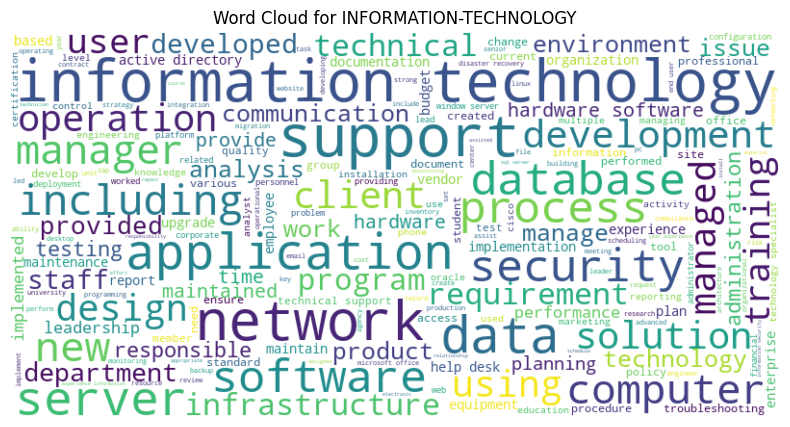

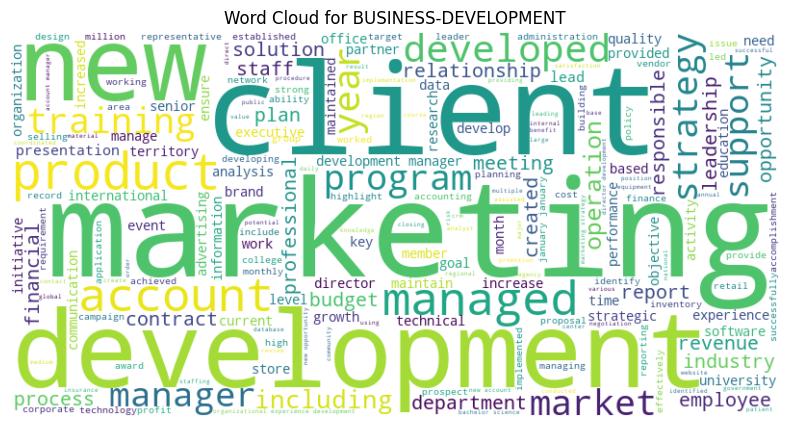

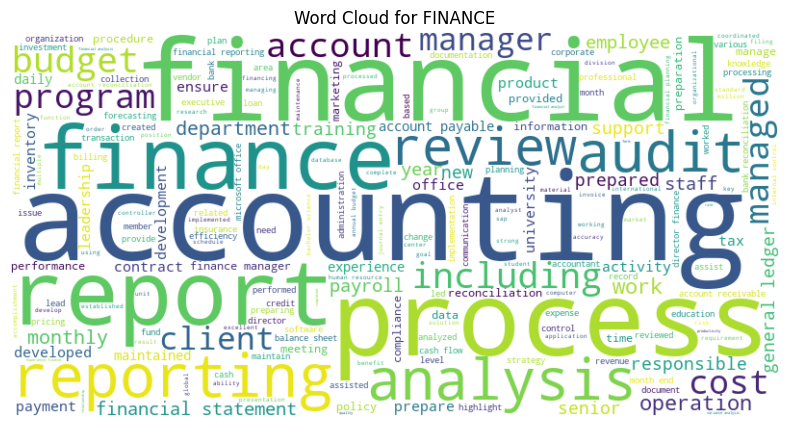

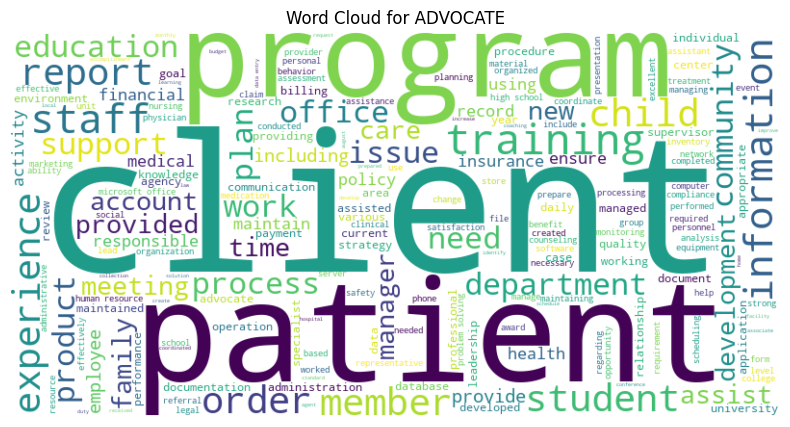

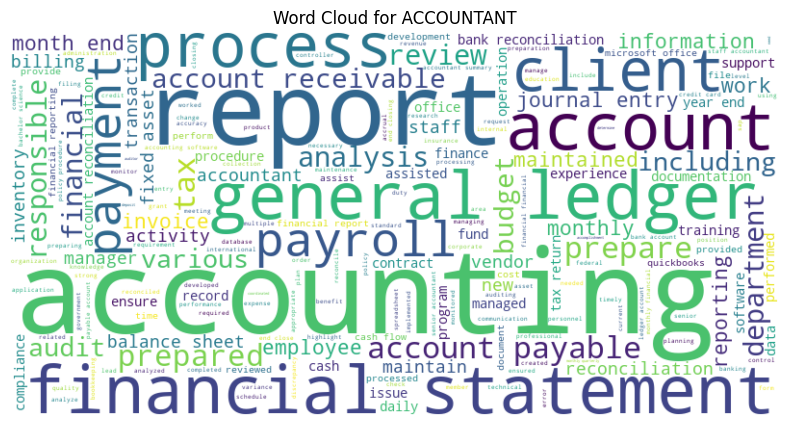

In [95]:
example_idx = 1
original_text = df_filtered.iloc[example_idx]['Resume_str']
cleaned_text = df_filtered.iloc[example_idx]['Cleaned_Resume_str']

print("original resume:\n", original_text)
print("\nclean resume:\n", cleaned_text)

# Change the original Resume_str to the clean str and drop the Cleaned_Resume_str column
df_filtered['Resume_str'] = df_filtered['Cleaned_Resume_str']
df_filtered = df_filtered.drop(columns=['Cleaned_Resume_str'])

# Generate word clouds for the top 5 categories
for category in top_categories:
    generate_wordcloud(df_filtered, category)

# Save
Looks good! let's save the new dataframe and run it through the model

In [98]:
# Save the filtered data to a new CSV file
filtered_csv_path = 'dataset/Resume/filtered-Resume.csv'
df_filtered.to_csv(filtered_csv_path, index=False)
print(f"Filtered data saved to {filtered_csv_path}")

Filtered data saved to dataset/Resume/filtered-Resume.csv
